In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import torch

device = torch.device("cpu")
color_label = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=14)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.cm.tab20)
color_map = [scalarMap.to_rgba(i) for i in range(14)]

In [2]:
def plot(adj, feat, pos, ax, seed=0):
    plt.axis('off')
    G = nx.from_numpy_matrix(org_adj[0].numpy())
    sub_G = nx.from_numpy_matrix(adj[0].numpy())
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    sub_G = sub_G.subgraph(largest_cc).copy()
    node_labels = dict([(n, n) for n in sub_G])
    fixed_nodes = pos.keys()
    if fixed_nodes:
        fixed_nodes = list(G.nodes)
        _pos = nx.spring_layout(G, seed=seed, pos=pos, fixed=fixed_nodes)
    else:
        fixed_nodes = list(G.nodes)
        if layout == 'spring':
            _pos = nx.spring_layout(G, seed=seed)
        elif layout == 'kamada_kawai':
            _pos = nx.kamada_kawai_layout(G)
    pos.update(_pos)
    node_color = [color_map[np.where(feat[0][n]==1)[0][0]] if len(np.where(feat[0][n]==1)[0]) > 0 else color_map[0] for n in sub_G]

    nc = nx.draw_networkx_nodes(sub_G, pos, alpha=1, node_color=node_color, node_size=100, ax=ax)
    nx.draw_networkx_edges(sub_G, width=3, pos=pos, ax=ax)
    nx.draw_networkx_edges(G, alpha=0.2, width=3, pos=pos, ax=ax)
    plt.tight_layout()
    return pos

In [3]:
def plot_graph(graph_idx):
    print("Plotting explanations for graph %s" % graph_idx)
    data = torch.load("distillation/%s/graph_idx_%d.ckpt" %(distillation, graph_idx), map_location=device)
    sub_label = data['label'].to(device)
    global org_adj
    org_adj = torch.from_numpy(np.int64(data['adj']>0)).unsqueeze(0).to(device).float()
    G = nx.from_numpy_matrix(data['adj'])
    G3 = nx.from_numpy_array(data['adj_y'])
    extracted_adj = torch.from_numpy(nx.to_numpy_matrix(G3, weight=None)).unsqueeze(0).float()
    sub_feat = data['features']

    recovered = np.loadtxt("explanation/%s/graph_idx_%d_pred.csv"%(explanation, graph_idx), delimiter=',')
    ours_adj = recovered * data['adj']

    ### Top K ###
    num_nodes = ours_adj.shape[-1]
    adj_threshold_num = top_k * 2
    neigh_size = len(ours_adj[ours_adj > 0])
    threshold_num = min(neigh_size, adj_threshold_num)
    threshold = np.sort(ours_adj[ours_adj > 0])[-threshold_num]

    weighted_edge_list = [
        (i, j, ours_adj[i, j])
        for i in range(num_nodes)
        for j in range(num_nodes)
        if ours_adj[i, j] >= threshold
    ]
    G2 = nx.Graph()
    G2.add_nodes_from(range(num_nodes))
    G2.add_weighted_edges_from(weighted_edge_list)
    ours_adj = nx.to_numpy_matrix(G2, weight=None)
    ours_adj = torch.from_numpy(ours_adj).unsqueeze(0).float()
    

    gnnexp_data = torch.load(os.path.join(gnnexp_result_path, 'masked_adj_node_idx_0graph_idx_%s.ckpt' % graph_idx), map_location=device)
    gnnexp_label = sub_label
    gnnexp_adj = gnnexp_data['adj']

    ### Top K ###
    num_nodes = gnnexp_adj.shape[-1]
    adj_threshold_num = top_k * 2
    neigh_size = len(gnnexp_adj[gnnexp_adj > 0])
    threshold_num = min(neigh_size, adj_threshold_num)
    threshold = np.sort(gnnexp_adj[gnnexp_adj > 0])[-threshold_num]

    weighted_edge_list = [
        (i, j, gnnexp_adj[i, j])
        for i in range(num_nodes)
        for j in range(num_nodes)
        if gnnexp_adj[i, j] >= threshold
    ]
    G2 = nx.Graph()
    G2.add_nodes_from(range(num_nodes))
    G2.add_weighted_edges_from(weighted_edge_list)
    gnnexp_adj = nx.to_numpy_matrix(G2, weight=None)

    gnnexp_adj = torch.from_numpy(gnnexp_adj).unsqueeze(0).float()
    graph_label = data["label"]
    pos = dict({})
    fig, ax = plt.subplots(figsize=(4,4))
    pos = plot(org_adj, sub_feat, pos, ax, seed)
    plt.show()
    plt.close()
    
    print("Distillation from %s" % distillation)
    fig, ax = plt.subplots(figsize=(4,4))
    pos = plot(extracted_adj, sub_feat, pos, ax)
    plt.show()
    plt.close()

    print("Gem's explanation with top %d edges:" % top_k)
    fig, ax = plt.subplots(figsize=(4,4))
    pos = plot(ours_adj, sub_feat, pos, ax)
    plt.show()
    plt.close()

    print("GNNExplainer's explanation with top %d edges:" % top_k)
    fig, ax = plt.subplots(figsize=(4,4))
    pos = plot(gnnexp_adj, sub_feat, pos, ax)
    plt.show()
    plt.close()

In [4]:
distillation = 'mutag_top20'
explanation = 'mutag_top20'
gnnexp_result_path = 'explanation/gnnexp/Mutagenicity_base_h20_o20_explain'

Plotting explanations for graph 3942


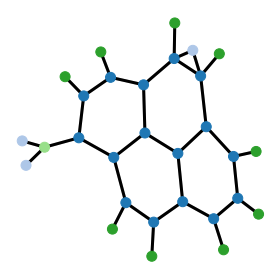

Distillation from mutag_top20


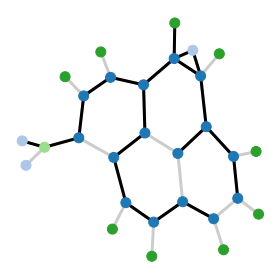

Gem's explanation with top 15 edges:


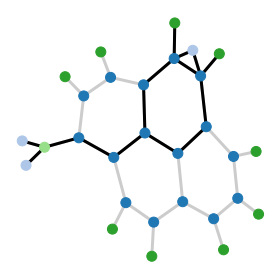

GNNExplainer's explanation with top 15 edges:


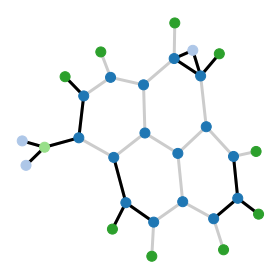

In [5]:
seed = 4
top_k = 15
layout = 'spring'
plot_graph(3942)

Plotting explanations for graph 3907


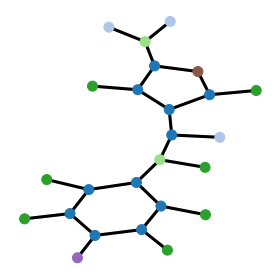

Distillation from mutag_top20


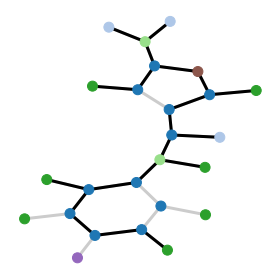

Gem's explanation with top 15 edges:


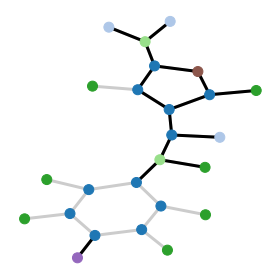

GNNExplainer's explanation with top 15 edges:


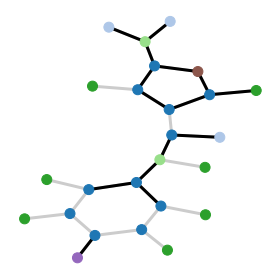

In [6]:
seed = 0
top_k = 15
layout = 'kamada_kawai'
plot_graph(3907)

Plotting explanations for graph 3937


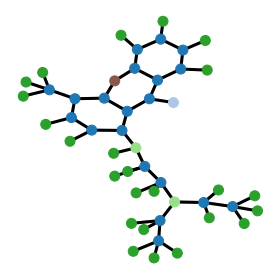

Distillation from mutag_top20


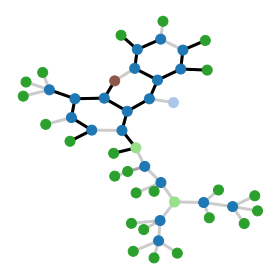

Gem's explanation with top 15 edges:


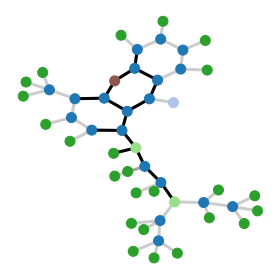

GNNExplainer's explanation with top 15 edges:


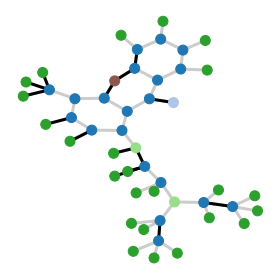

In [7]:
seed = 0
top_k = 15
layout = 'kamada_kawai'
plot_graph(3937)

Plotting explanations for graph 3944


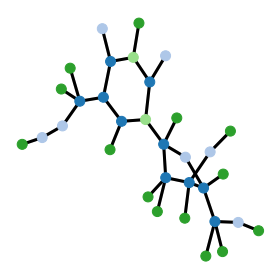

Distillation from mutag_top20


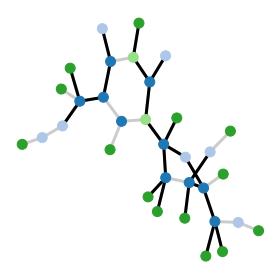

Gem's explanation with top 15 edges:


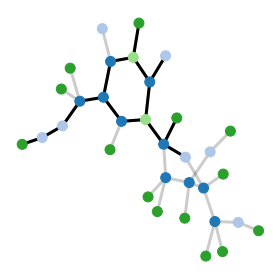

GNNExplainer's explanation with top 15 edges:


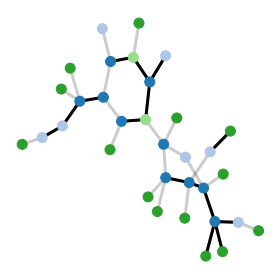

In [8]:
seed = 0
top_k = 15
layout = 'kamada_kawai'
plot_graph(3944)